**In this demo, we will first build a shallow neural network from scratch, then use TensorFlow framework to compare results.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
import sklearn.linear_model

np.random.seed(915)

# Circular data classification with one hidden layer

First, we generate 500 examples with 2 classes. Note that we need examples to be in columns.

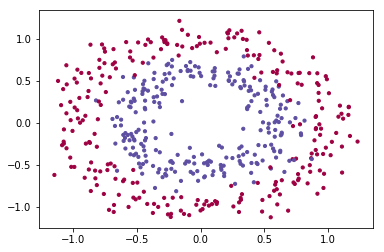

In [2]:
X, Y = make_circles(n_samples = 500, noise=0.12, factor = 0.6)
# reshape into 2d array, examples stacked by columns
X = X.T
Y = Y.reshape(1, -1)
# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=10, cmap=plt.cm.Spectral)
plt.show()

In [3]:
print(X.shape)
print(Y.shape)

(2, 500)
(1, 500)


## Logistic Regression

Before building a neural network, let's see how logistic regression work on this problem.

In [4]:
clf = sklearn.linear_model.LogisticRegressionCV(cv=5)
clf.fit(X.T, Y.reshape(-1,))

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Let's plot the decision boundary of logistic regression

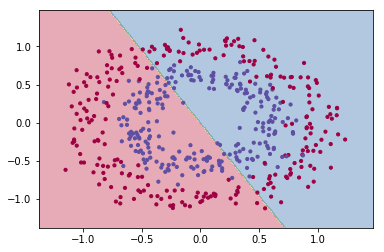

In [5]:
x_min, x_max = np.min(X) * 1.2, np.max(X) * 1.2
x1, x2 = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(x_min, x_max, 0.01))
z = clf.predict(np.c_[x1.reshape(-1,), x2.reshape(-1,)])
plt.contourf(x1, x2, z.reshape(x1.shape), cmap=plt.cm.Spectral, alpha = 0.4)
plt.scatter(X[0, :], X[1, :], c=Y, s=10, cmap=plt.cm.Spectral)
plt.show()

What about training error?

In [6]:
LR_error = np.mean(Y != clf.predict(X.T))
print(LR_error)

0.504


**Interpretation**: the dataset is not linearly separbale, so logistic regression cannot train well and underfit.

How about test error? Let's generate another 500 examples.

In [7]:
X_test, Y_test = make_circles(n_samples = 500, noise=0.12, factor = 0.6)
# reshape into 2d array, examples stacked by columns
X_test = X_test.T
Y_test = Y_test.reshape(1, -1)
test_error_LR = np.mean(Y_test != clf.predict(X_test.T))
print(test_error_LR)

0.496


## Neural Network

We will use a neural network with 1 hidden layer and see whether this is a better model than logistic regression.
For one example $x^{(i)}$, the **forward propagation** is as follows:
$$
z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}
$$
$$
a^{[1] (i)} = g(z^{[1] (i)})
$$
$$
z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}
$$
$$
\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})
$$

Given the predictions on all the examples, the cost $J$ is: 
$$
J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small
$$

### Defining architecture

The first step is to define # of layer, # of input units (n_x), # of hidden units (n_h), # of output units (n_y). 

We have only 1 hidden layer, n_x=2 and n_y = 1. Say we are using 4 hidden units, n_h=4.

### Initialize parameters

We will initialize weight matrices with small random values, and bias vectors to 0.

In [8]:
n_x, n_h, n_y = 2, 4, 1
W1 = np.random.randn(n_h, n_x) * 0.01
b1 = np.zeros((n_h, 1))
W2 = np.random.rand(n_y, n_h) * 0.01
b2 = np.zeros((n_y, 1))
print(W1)
print(b1)
print(W2)
print(b2)

[[-0.00166847 -0.0064864 ]
 [ 0.01995897  0.01772089]
 [-0.00275071 -0.00062434]
 [-0.0161685   0.01770934]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.00223612 0.00927107 0.00191549 0.0062068 ]]
[[0.]]


### Forward Propagation

Define function for forward propagation using equations above. Use sigmoid function as activation function.

We will cache the output from layer of calculation, which is used in back propagation later on.

In [9]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))
    
def forward_propagation(X, parameters):
    W1, b1, W2, b2 = parameters
    Z1 = W1 @ X + b1
    A1 = sigmoid(Z1)
    Z2 = W2 @ A1 + b2
    A2 = sigmoid(Z2)
    
    cache = {"A1":A1, "A2":A2}
    return A2, cache

We now define the function to compute the cost according to log loss:

In [10]:
def compute_cost(A2, Y):
    return np.mean(-Y * np.log(A2) - (1-Y) * np.log(1-A2))

### Backward Propagation

For one example $x^{(i)}$, the **backward propagation** is as follows:
$$
\frac{\partial L}{\partial a^{[2]}} = -\frac{y}{a^{[2]}} + \frac{1-y}{1-a^{[2]}}
$$
$$
\frac{\partial L}{\partial z^{[2]}} = \frac{\partial L}{\partial a^{[2]}} \frac{\partial a^{[2]}}{\partial z^{[2]}}=\left(-\frac{y}{a^{[2]}} + \frac{1-y}{1-a^{[2]}}\right)a^{[2]}(1-a^{[2]})=a^{[2]}-y
$$
$$
\frac{\partial L}{\partial W^{[2]}} = \frac{\partial L}{\partial z^{[2]}} \frac{\partial z^{[2]}}{\partial W^{[2]}}=\frac{\partial L}{\partial z^{[2]}} a^{[2]\top}
$$
$$
\frac{\partial L}{\partial b^{[2]}} = \frac{\partial L}{\partial z^{[2]}} \frac{\partial z^{[2]}}{\partial b^{[2]}}=\frac{\partial L}{\partial z^{[2]}}
$$
$$
\frac{\partial L}{\partial a^{[1]}} = \frac{\partial L}{\partial z^{[2]}} \frac{\partial z^{[2]}}{\partial a^{[1]}}=W^{[2]\top}\frac{\partial L}{\partial z^{[2]}}
$$
$$
\frac{\partial L}{\partial z^{[1]}} = \frac{\partial L}{\partial a^{[1]}} \frac{\partial a^{[1]}}{\partial z^{[1]}}=\frac{\partial L}{\partial a^{[1]}}a^{[1]}(1-a^{[1]})
$$
$$
\frac{\partial L}{\partial W^{[1]}} = \frac{\partial L}{\partial z^{[1]}} \frac{\partial z^{[1]}}{\partial W^{[1]}}=\frac{\partial L}{\partial z^{[1]}}x^\top
$$
$$
\frac{\partial L}{\partial b^{[1]}} = \frac{\partial L}{\partial z^{[1]}} \frac{\partial z^{[1]}}{\partial b^{[1]}}=\frac{\partial L}{\partial z^{[1]}}
$$

In [11]:
def backward_propagation(X, Y, parameters, cache):
    m = X.shape[1]
    W1, b1, W2, b2 = parameters
    A1, A2 = cache["A1"], cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = dZ2 @ A2.T / m
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T @ dZ2 * (A1 * (1 - A1))
    dW1 = dZ1 @ X.T / m
    db1 = np.mean(dZ1, axis=1, keepdims=True)
    
    # return gradients
    grads = {"W1":dW1, "b1":db1, "W2":dW2, "b2":db2}
    return grads

### Gradient Descent

Having computed gradients from backpropagation, we can now update parameters using gradient descent. For each step of gradient descent, we have:

In [12]:
def update_parameters(parameters, grads, learning_rate):
    W1, b1, W2, b2 = parameters
    W1 -= learning_rate * grads["W1"]
    b1 -= learning_rate * grads["b1"]
    W2 -= learning_rate * grads["W2"]
    b2 -= learning_rate * grads["b2"]
    return (W1, b1, W2, b2)

### Wrapping everything together

In [13]:
def train_snn(X, Y, learning_rate, n_iter):
    parameters = (W1, b1, W2, b2)
    for i in range(n_iter):
        # forward propagation
        A2, cache = forward_propagation(X, parameters)
        # backward propagation
        grads = backward_propagation(X, Y, parameters, cache)
        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # print cost for every 5000 iterations
        if (i+1) % 5000 == 0:
            cost = compute_cost(A2, Y)
            print("Cost after {} iterations: {}".format(i+1, cost))
    return parameters
parameters = train_snn(X, Y, 1.2, 40000)

Cost after 5000 iterations: 0.6931463443710536
Cost after 10000 iterations: 0.6931454201381388
Cost after 15000 iterations: 0.6931436297710959
Cost after 20000 iterations: 0.6931388205555653
Cost after 25000 iterations: 0.6931180357512275
Cost after 30000 iterations: 0.6926357961221672
Cost after 35000 iterations: 0.11111940063728934
Cost after 40000 iterations: 0.10221360651748396


Prediction with neural network

In [14]:
def predict_snn(X, parameters):
    y_pred, _ = forward_propagation(X, parameters)
    return y_pred > 0.5

Let's plot the decision boundary of this neural network

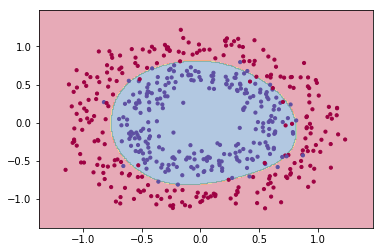

In [15]:
z = predict_snn(np.c_[x1.reshape(-1,), x2.reshape(-1,)].T, parameters)
plt.contourf(x1, x2, z.reshape(x1.shape), cmap=plt.cm.Spectral, alpha = 0.4)
plt.scatter(X[0, :], X[1, :], c=Y, s=10, cmap=plt.cm.Spectral)
plt.show()

What's the test error?

In [16]:
test_error_snn = np.mean(Y_test != predict_snn(X_test, parameters))
print(test_error_snn)

0.052


**Interpretation**: we learned a non-linear decision function with a hidden layer. The test error is much smaller than that in logistic regression. 

## TensorFlow

In [17]:
import tensorflow as tf
from tensorflow.python.framework import ops

In [18]:
def tf_snn(X_train, Y_train, X_test, Y_test, learning_rate, n_iter):
    n = X_train.shape[0]
    ops.reset_default_graph()
    
    # create placeholder for input data and labels
    X = tf.placeholder(tf.float64, shape=(n, None), name="X")
    Y = tf.placeholder(tf.float64, shape=(1, None), name="Y")
    
    # initialize parameters
    W1 = tf.get_variable("W1", shape=(4, n), dtype=tf.float64,
                         initializer=tf.random_normal_initializer(mean=0, stddev=0.01))
    b1 = tf.get_variable("b1", shape=(4, 1), dtype=tf.float64,
                         initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", shape=(1, 4), dtype=tf.float64,
                     initializer=tf.random_normal_initializer(mean=0, stddev=0.01))
    b2 = tf.get_variable("b2", shape=(1, 1), dtype=tf.float64,
                     initializer=tf.zeros_initializer())
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    
    # forward propagation
    Z1 = tf.matmul(W1, X) + b1
    A1 = tf.sigmoid(Z1)
    Z2 = tf.matmul(W2, A1) + b2
    A2 = tf.sigmoid(Z2)
    
    # cost function
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2, labels=Y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    # training
    with tf.Session() as sess:
        sess.run(init)
        for i in range(n_iter):
            # compute cost
            if (i+1) % 5000 == 0:
                cur_cost = sess.run(cost, feed_dict={X:X_train, Y:Y_train.astype(np.float64)})
                print("Cost after {} iterations: {}".format(i+1, cur_cost))
            # one step of gradient descent
            sess.run(optimizer, feed_dict={X:X_train, Y:Y_train.astype(np.float64)})
        # save parameters
        parameters = sess.run(parameters)
        
        # predict test labels
        test_pred = sess.run(A2, feed_dict={X:X_test, Y:Y_test.astype(np.float64)}) 
    return parameters, test_pred

In [19]:
params, y_pred = tf_snn(X, Y, X_test, Y_test, 1.2, 40000)

Cost after 5000 iterations: 0.5643280978703313
Cost after 10000 iterations: 0.12051535548906504
Cost after 15000 iterations: 0.10669160517860235
Cost after 20000 iterations: 0.10283329397200926
Cost after 25000 iterations: 0.10122116409029565
Cost after 30000 iterations: 0.10029299504888244
Cost after 35000 iterations: 0.0996782685916819
Cost after 40000 iterations: 0.09923950055385157


What's the test error?

In [20]:
test_error_tf_snn = np.mean(Y_test != (y_pred > 0.5))
print(test_error_tf_snn)

0.052
